# 데이터 임포트

In [54]:
! mkdir data
! unzip /content/drive/MyDrive/projects/oden_anomalydetection/wando_sample.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  /content/drive/MyDrive/projects/oden_anomalydetection/wando_sample.zip
replace data/wando1_oxygen(9.15~10.14).xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
import pandas as pd
import ast

In [56]:
df1 = pd.read_excel("data/wando1_oxygen(9.15~10.14).xlsx")
df2 = pd.read_excel("data/wando2_oxygen(8.15~9.15).xlsx")
df3 = pd.read_excel("data/wando2_oxygen(9.15~10.14).xlsx")

In [57]:
df = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [58]:
df.isnull().sum()

,0
device_id,0
device_type,0
measure_time,0
serial_number,0
coordinates,0
temperature,0
oxygen_mpl,0
oxygen_per,0
oxygen_ppm,0
timestamp,0


In [59]:
df.duplicated().sum()

0

# 데이터 전처리 및 EDA

In [60]:
import matplotlib.pyplot as plt

In [61]:
df.columns

Index(['device_id', 'device_type', 'measure_time', 'serial_number',
       'coordinates', 'temperature', 'oxygen_mpl', 'oxygen_per', 'oxygen_ppm',
       'timestamp', 'date_time'],
      dtype='object')

In [62]:
df = df[['device_id', 'date_time', 'temperature', 'oxygen_ppm']]

In [63]:
df['date_time'] = pd.to_datetime(df['date_time'])

<ipython-input-63-54f94f09751c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_time'] = pd.to_datetime(df['date_time'])


In [64]:
col_li = ['temperature', 'oxygen_ppm']

In [65]:
for col in col_li:
  df[col] = df[col].apply(ast.literal_eval)
  df[col] = df[col].apply(lambda x: x['value'])

In [66]:
df.dtypes

,0
device_id,object
date_time,datetime64[ns]
temperature,float64
oxygen_ppm,float64


In [67]:
pd.to_datetime(df['date_time'])

,date_time
0,2024-09-15 00:58:58
1,2024-09-15 00:57:54
2,2024-09-15 00:56:50
3,2024-09-15 00:55:45
4,2024-09-15 00:54:41
...,...
98804,2024-10-13 23:04:49
98805,2024-10-13 23:03:45
98806,2024-10-13 23:02:41
98807,2024-10-13 23:01:36


In [68]:
abnormal_df = df[df['device_id']=="wando01"].reset_index(drop=True)
normal_df = df[df['device_id']=="wando02"].reset_index(drop=True)

In [69]:
abnormal_df.set_index('date_time', inplace=True)
abnormal_df['temperature'] = abnormal_df['temperature'].astype(float)
abnormal_df['oxygen_ppm'] = abnormal_df['oxygen_ppm'].astype(float)

# 2분 단위로 리샘플링 (평균값을 계산)
abnormal_df = abnormal_df.resample('2min').ffill().reset_index()
abnormal_df = abnormal_df.dropna()

normal_df.set_index('date_time', inplace=True)
normal_df['temperature'] = normal_df['temperature'].astype(float)
normal_df['oxygen_ppm'] = normal_df['oxygen_ppm'].astype(float)

# 2분 단위로 리샘플링 (평균값을 계산)
normal_df = normal_df.resample('2min').ffill().reset_index()
normal_df = normal_df.dropna()

In [70]:
print(normal_df['oxygen_ppm'].quantile(0.001))
print(normal_df['oxygen_ppm'].quantile(0.01))
print(normal_df['oxygen_ppm'].quantile(0.025))
print(normal_df['oxygen_ppm'].quantile(0.05))
print(normal_df['oxygen_ppm'].quantile(0.1))
print(normal_df['oxygen_ppm'].quantile(0.2))
print(normal_df['oxygen_ppm'].quantile(0.3))

0.0
0.19874110579490667
1.258803749084473
5.503450965881347
5.9994464874267575
6.207117366790771
6.385161685943603


In [71]:
print(abnormal_df['oxygen_ppm'].quantile(0.1))
print(abnormal_df['oxygen_ppm'].quantile(0.125))
print(abnormal_df['oxygen_ppm'].quantile(0.15))
print(abnormal_df['oxygen_ppm'].quantile(0.175))
print(abnormal_df['oxygen_ppm'].quantile(0.2))
print(abnormal_df['oxygen_ppm'].quantile(0.3))
print(abnormal_df['oxygen_ppm'].quantile(0.7))
print(abnormal_df['oxygen_ppm'].quantile(0.9))
print(abnormal_df['oxygen_ppm'].quantile(0.95))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.667492151260376
1.1632304549217218


In [72]:
normal_df.describe()

,date_time,temperature,oxygen_ppm
count,43199,43199.000000,43199.000000
mean,2024-09-14 00:00:00,26.433259,6.527795
min,2024-08-15 00:02:00,22.862270,0.000000
25%,2024-08-30 00:01:00,25.287548,6.291179
50%,2024-09-14 00:00:00,26.879158,6.692082
75%,2024-09-28 23:59:00,27.445118,7.205723
max,2024-10-13 23:58:00,30.838661,8.661695
std,NaN,1.645964,1.176183


In [73]:
abnormal_df.describe()

,date_time,temperature,oxygen_ppm
count,20879,20879.000000,20879.000000
mean,2024-09-29 12:00:00,25.667529,0.184612
min,2024-09-15 00:02:00,22.321861,0.000000
25%,2024-09-22 06:01:00,23.465959,0.000000
50%,2024-09-29 12:00:00,26.226765,0.000000
75%,2024-10-06 17:59:00,27.471806,0.081942
max,2024-10-13 23:58:00,29.978992,3.317342
std,NaN,2.131632,0.458325


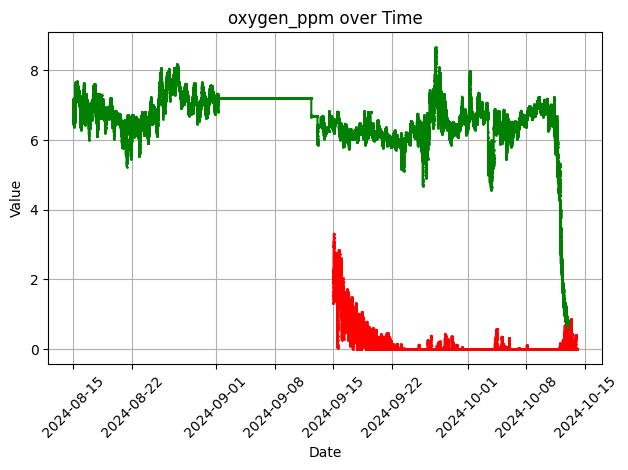

In [74]:
# 그래프 그리기
target = 'oxygen_ppm'
plt.plot(normal_df['date_time'], normal_df[target], marker='.', color='green', markersize=2)
plt.plot(abnormal_df['date_time'], abnormal_df[target], marker='.', color='red', markersize=2)
plt.title(f'{target} over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

oxygen ppm이 3이하가 지속될 경우 용존산소 센서 이상일 가능성이 매우 높다.

그리고 센서 이상이 생길 시 용존산소에 급격한 변화를 보이는 것으로 추정되는데,

wando2(normal_df)의 경우에도 10월 10일 이후 센서의 이상이 확인된다.

In [126]:
#normal_df2 = normal_df[normal_df['date_time']<='2024-10-13']
normal_df2 = normal_df.copy()

In [127]:
normal_df2

,date_time,device_id,temperature,oxygen_ppm
1,2024-08-15 00:02:00,wando02,25.811529,7.028381
2,2024-08-15 00:04:00,wando02,25.867359,6.981632
3,2024-08-15 00:06:00,wando02,25.800680,7.166407
4,2024-08-15 00:08:00,wando02,25.803490,7.072851
5,2024-08-15 00:10:00,wando02,25.815384,7.026972
...,...,...,...,...
43195,2024-10-13 23:50:00,wando02,23.304644,0.000000
43196,2024-10-13 23:52:00,wando02,23.304583,0.000000
43197,2024-10-13 23:54:00,wando02,23.306885,0.000000
43198,2024-10-13 23:56:00,wando02,23.306078,0.000000


# 학습용 데이터 구축

In [128]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Parameters
sequence_length = 30  # 1 hour sequences (30 time steps of 2 minutes)
features = ['oxygen_ppm']

# Function to create sequences from the data
def create_sequences(df, label):
    df = df.sort_values('date_time').reset_index(drop=True)
    data = df[features].values
    sequences = []
    labels = []
    num_sequences = len(data) - sequence_length + 1
    for i in range(num_sequences):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return sequences, labels

In [129]:
# Create sequences for normal data (label=0)
normal_sequences, normal_labels = create_sequences(normal_df2, label=0)

# Create sequences for abnormal data (label=1)
abnormal_sequences, abnormal_labels = create_sequences(abnormal_df, label=1)

In [130]:
# Combine normal and abnormal data
all_sequences = np.concatenate([normal_sequences, abnormal_sequences], axis=0)
all_labels = np.concatenate([normal_labels, abnormal_labels], axis=0)

# Shuffle the data
indices = np.arange(len(all_sequences))
np.random.shuffle(indices)
all_sequences = all_sequences[indices]
all_labels = all_labels[indices]

In [131]:
# Define PyTorch Dataset
class OxygenDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create the dataset
dataset = OxygenDataset(all_sequences, all_labels)

# Example usage with DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [132]:
from torch.utils.data import random_split

# Parameters for train/validation/test split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate lengths for each split
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no leftover samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage with train DataLoader
for batch_sequences, batch_labels in train_dataloader:
    # batch_sequences shape: [batch_size, sequence_length, num_features]
    # batch_labels shape: [batch_size]
    # Here you would pass batch_sequences to your GRU model for training
    pass  # Replace with your training code

In [133]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

44814 9603 9603


# AI 모델 학습

In [134]:
! mkdir checkpoint

mkdir: cannot create directory ‘checkpoint’: File exists


In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Define GRU-based model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)  # out: [batch_size, seq_len, hidden_size]
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Model parameters
input_size = len(features)  # Number of features (e.g., temperature, oxygen_ppm)
hidden_size = 32
output_size = 2  # Binary classification (normal/abnormal)
num_layers = 1
epochs = 20
learning_rate = 0.001
best_val_loss = float('inf')
best_model_path = "checkpoint/best_gru_model.pth"

In [160]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model, define loss function and optimizer
model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to reduce learning rate if validation loss does not improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping parameters
early_stop_patience = 5
no_improvement_count = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []

Using device: cuda


In [161]:
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Add tqdm for training progress visualization
    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Training")
    for batch_sequences, batch_labels in train_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Validation")
        for batch_sequences, batch_labels in val_loader_tqdm:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = correct_predictions / total_predictions
    val_losses.append(val_epoch_loss)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        print("===============================================================================================")
        no_improvement_count = 0  # Reset early stopping counter
    else:
        no_improvement_count += 1

    # Reduce learning rate if validation loss does not improve
    scheduler.step(val_epoch_loss)

    # Early stopping check
    if no_improvement_count >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch [1/20] Training: 100%|██████████| 701/701 [00:03<00:00, 218.36it/s]


Epoch [1/20], Loss: 0.0965, Accuracy: 0.9669


Epoch [1/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 905.89it/s]


Validation Loss: 0.0724, Validation Accuracy: 0.9770
Best model saved with validation loss: 0.0724


Epoch [2/20] Training: 100%|██████████| 701/701 [00:01<00:00, 354.62it/s]


Epoch [2/20], Loss: 0.0685, Accuracy: 0.9790


Epoch [2/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 970.53it/s]


Validation Loss: 0.0679, Validation Accuracy: 0.9783
Best model saved with validation loss: 0.0679


Epoch [3/20] Training: 100%|██████████| 701/701 [00:03<00:00, 211.54it/s]


Epoch [3/20], Loss: 0.0667, Accuracy: 0.9791


Epoch [3/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 662.04it/s]


Validation Loss: 0.0664, Validation Accuracy: 0.9778
Best model saved with validation loss: 0.0664


Epoch [4/20] Training: 100%|██████████| 701/701 [00:02<00:00, 277.86it/s]


Epoch [4/20], Loss: 0.0664, Accuracy: 0.9792


Epoch [4/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 628.65it/s]


Validation Loss: 0.0661, Validation Accuracy: 0.9778
Best model saved with validation loss: 0.0661


Epoch [5/20] Training: 100%|██████████| 701/701 [00:02<00:00, 235.91it/s]


Epoch [5/20], Loss: 0.0654, Accuracy: 0.9791


Epoch [5/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 888.05it/s]


Validation Loss: 0.0665, Validation Accuracy: 0.9780


Epoch [6/20] Training: 100%|██████████| 701/701 [00:01<00:00, 352.84it/s]


Epoch [6/20], Loss: 0.0644, Accuracy: 0.9794


Epoch [6/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 899.08it/s]


Validation Loss: 0.0621, Validation Accuracy: 0.9774
Best model saved with validation loss: 0.0621


Epoch [7/20] Training: 100%|██████████| 701/701 [00:01<00:00, 359.96it/s]


Epoch [7/20], Loss: 0.0632, Accuracy: 0.9791


Epoch [7/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 952.97it/s]


Validation Loss: 0.0638, Validation Accuracy: 0.9775


Epoch [8/20] Training: 100%|██████████| 701/701 [00:02<00:00, 326.94it/s]


Epoch [8/20], Loss: 0.0627, Accuracy: 0.9794


Epoch [8/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 651.16it/s]


Validation Loss: 0.0649, Validation Accuracy: 0.9782


Epoch [9/20] Training: 100%|██████████| 701/701 [00:02<00:00, 258.22it/s]


Epoch [9/20], Loss: 0.0620, Accuracy: 0.9794


Epoch [9/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 702.45it/s]


Validation Loss: 0.0666, Validation Accuracy: 0.9781


Epoch [10/20] Training: 100%|██████████| 701/701 [00:01<00:00, 350.57it/s]


Epoch [10/20], Loss: 0.0617, Accuracy: 0.9796


Epoch [10/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 805.75it/s]


Validation Loss: 0.0617, Validation Accuracy: 0.9781
Best model saved with validation loss: 0.0617


Epoch [11/20] Training: 100%|██████████| 701/701 [00:01<00:00, 352.50it/s]


Epoch [11/20], Loss: 0.0616, Accuracy: 0.9796


Epoch [11/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 947.26it/s]


Validation Loss: 0.0618, Validation Accuracy: 0.9787


Epoch [12/20] Training: 100%|██████████| 701/701 [00:02<00:00, 344.75it/s]


Epoch [12/20], Loss: 0.0617, Accuracy: 0.9793


Epoch [12/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 946.01it/s]


Validation Loss: 0.0600, Validation Accuracy: 0.9776
Best model saved with validation loss: 0.0600


Epoch [13/20] Training: 100%|██████████| 701/701 [00:01<00:00, 351.88it/s]


Epoch [13/20], Loss: 0.0623, Accuracy: 0.9790


Epoch [13/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 925.14it/s]


Validation Loss: 0.0599, Validation Accuracy: 0.9778
Best model saved with validation loss: 0.0599


Epoch [14/20] Training: 100%|██████████| 701/701 [00:02<00:00, 310.68it/s]


Epoch [14/20], Loss: 0.0608, Accuracy: 0.9796


Epoch [14/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 604.16it/s]


Validation Loss: 0.0595, Validation Accuracy: 0.9779
Best model saved with validation loss: 0.0595


Epoch [15/20] Training: 100%|██████████| 701/701 [00:03<00:00, 191.54it/s]


Epoch [15/20], Loss: 0.0607, Accuracy: 0.9796


Epoch [15/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 323.78it/s]


Validation Loss: 0.0594, Validation Accuracy: 0.9780
Best model saved with validation loss: 0.0594


Epoch [16/20] Training: 100%|██████████| 701/701 [00:02<00:00, 258.09it/s]


Epoch [16/20], Loss: 0.0603, Accuracy: 0.9794


Epoch [16/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 730.21it/s]


Validation Loss: 0.0593, Validation Accuracy: 0.9780
Best model saved with validation loss: 0.0593


Epoch [17/20] Training: 100%|██████████| 701/701 [00:02<00:00, 296.23it/s]


Epoch [17/20], Loss: 0.0598, Accuracy: 0.9795


Epoch [17/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 931.73it/s]


Validation Loss: 0.0588, Validation Accuracy: 0.9777
Best model saved with validation loss: 0.0588


Epoch [18/20] Training: 100%|██████████| 701/701 [00:02<00:00, 336.45it/s]


Epoch [18/20], Loss: 0.0593, Accuracy: 0.9796


Epoch [18/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 858.41it/s]


Validation Loss: 0.0602, Validation Accuracy: 0.9775


Epoch [19/20] Training: 100%|██████████| 701/701 [00:04<00:00, 174.66it/s]


Epoch [19/20], Loss: 0.0607, Accuracy: 0.9792


Epoch [19/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 435.51it/s]


Validation Loss: 0.0573, Validation Accuracy: 0.9790
Best model saved with validation loss: 0.0573


Epoch [20/20] Training: 100%|██████████| 701/701 [00:02<00:00, 257.72it/s]


Epoch [20/20], Loss: 0.0591, Accuracy: 0.9796


Epoch [20/20] Validation: 100%|██████████| 151/151 [00:00<00:00, 345.31it/s]

Validation Loss: 0.0598, Validation Accuracy: 0.9783


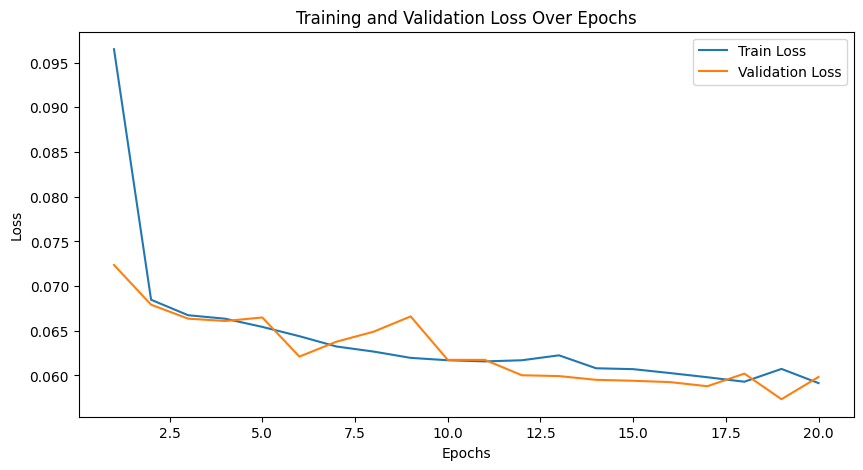

In [162]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# 검증

In [163]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [164]:
# Testing loop
all_labels = []
all_predictions = []
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
model.eval()

# Load the best model for testing
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded the best model for testing.")

Loaded the best model for testing.


<ipython-input-164-85e030398d66>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [165]:
with torch.no_grad():
    test_loader_tqdm = tqdm(test_dataloader, desc="Testing")
    for batch_sequences, batch_labels in test_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)
        all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test loss and accuracy
test_epoch_loss = test_loss / len(test_dataloader)
test_epoch_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")

Testing: 100%|██████████| 151/151 [00:00<00:00, 827.18it/s]

Test Loss: 0.0634, Test Accuracy: 0.9784


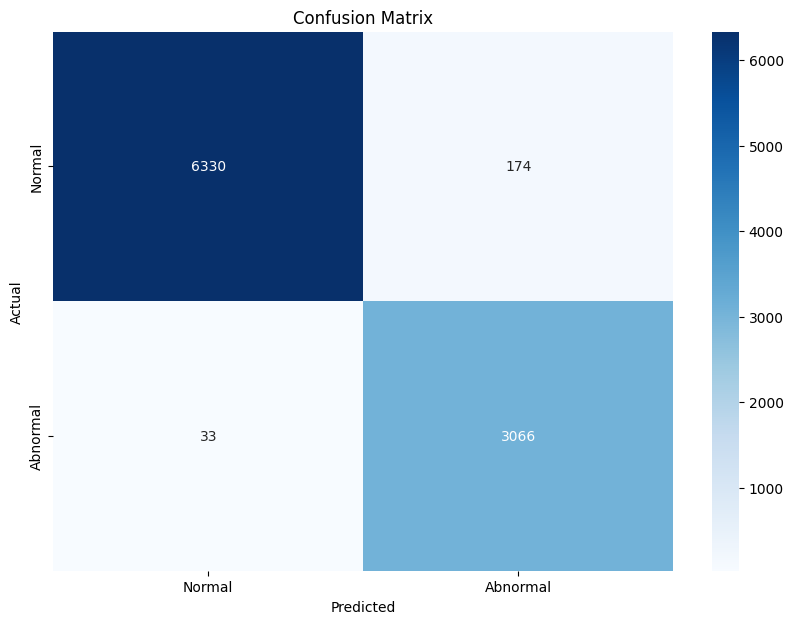

In [166]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [167]:
# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=['Normal', 'Abnormal'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      6504
    Abnormal       0.95      0.99      0.97      3099

    accuracy                           0.98      9603
   macro avg       0.97      0.98      0.98      9603
weighted avg       0.98      0.98      0.98      9603

